# Clean Code Cup 2024

https://cleancodecup.ru/problem/promopurchase

Задача - сделать максимально персонализированное промо предложение гостю. Что может быть в промо? Например - скидка в 10% при заказе от 1000 рублей (евро, долларов) или маленькая пицца в подарок/со скидкой. Вариантов много! Скидка также может быть предложена в процентах и в денежных единицах.

Ваша задача - научиться предсказывать воспользуется ли человек промо или проигнорирует. Чем точнее предсказание, тем более персонализированные предложения компания может делать своим клиентам

`orders.csv` - заказы клиентов (до ноября 10 последних заказов клиента)
- `OrderUUId` - уникальный id заказа
- `addressId` - адрес доставки
- `deliverySectorId` - сектор доставки
- `ClientUUId` - уникальный id клиента
- `Date` - день заказа
- `SaleDate` - время заказа
- `UnitUUId` - уникальный id пиццерии
- `NewClient` - 1, если это первый заказ у клиента. 0 иначе
- `ClientOrderNumber` - какой по счету заказ у клиента
- `ProductUUId` - уникальный id продукта
- `CategoryId` - id категории товара
- `ProductTotalPrice` - цена продукта с учетом примененных скидок
- `MenuPrice` - цена в меню
- `OrderState` - статус заказа
- `OrderPaymentType` - тип платежа
- `OrderTotalPrice` - общая сумма заказа
- `OrderType` - тип заказа
- `apply_promo` - 1, если применялся промокод. 0 иначе

`clients_promo_october.csv` - промо выданные за октябрь
- `ClientUUId` - уникальный id клиента
- `Id` - механика
- `LocalBeginDate` - старт кампании
- `LocalEndDate` - конец кампании
- `OrderType` - тип заказа
- `OrderPrice` - порог срабатывания
- `Discount` - вознаграждение


`train_target.csv` - промо выданные за октябрь с фактом заказа
- `ClientUUId` - уникальный id клиента
- `Id` - механика
- `OrderType` - тип заказа
- `LocalBeginDate` - старт кампании
- `LocalEndDate` - конец кампании
- `OrderPrice` - порог срабатывания
- `Discount` - вознаграждение
- `apply_promo`- факт использования промо (таргет)

`test.csv`
- `ClientUUId`
- `Id`
- `OrderType`
- `LocalBeginDate`
- `LocalEndDate`
- `OrderPrice`
- `Discount`

**OrderType**:
2,3 ресторан
1 доставка


Отправка результатов
Участникам необходимо в качестве ответа отправить csv файл, основанный на test.csv путем добавления в него целевого столбца apply_promo - вероятность применения промо. apply_promo может принимать значение от 0 до 1.

Оценка алгоритма
Метрикой задачи является

# Загрузка и анализ

In [1]:
!pip install pyarrow        # нужен для работы с датафреймами

In [2]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, LabelBinarizer


import datetime

## Promo_october

In [3]:
# промо выданные за октябрь
promo_oct = pd.read_csv("data/clients_promo_october.csv")
clients_po = set(promo_oct['ClientUUId'].unique())   # клиенты из таблицы заказов
promo_oct

ClientUUId  Id            LocalBeginDate  \
0       000D3A20F23EA95811E7B7104AC23CD3   6  2023-10-12T00:00:00.000Z   
1       000D3A20F23EA95811E7B7D79FAABAA1   5  2023-10-12T00:00:00.000Z   
2       000D3A20F23EA95811E7B8BD71C73877   7  2023-10-12T00:00:00.000Z   
3       000D3A20F23EA95811E7B99F3ED09FC8   6  2023-10-12T00:00:00.000Z   
4       000D3A20F23EA95811E7BD373E79565E   6  2023-10-12T00:00:00.000Z   
...                                  ...  ..                       ...   
477270  82EDCEB57826A0A811ED680C33F09E52   6  2023-10-30T00:00:00.000Z   
477271  82F78FC7401A9ADD11EDFA15A350D31F   5  2023-10-30T00:00:00.000Z   
477272  82F78FC7401AA4A811EDF992437D8CC6   5  2023-10-30T00:00:00.000Z   
477273  82F9662CB356B7E011EE167FC961059B   6  2023-10-30T00:00:00.000Z   
477274  8606F5E4CA39BF7211EE517E6E1D90B7   6  2023-10-30T00:00:00.000Z   

                    LocalEndDate OrderType  OrderPrice  Discount  
0       2023-10-15T23:59:00.000Z     1,2,3        1299        25  
1       2023-10-15T23:59:00.000Z     1,2,3        1299       300  
2       2023-10-15T23:59:00.000Z     1,2,3        1249       200  
3       2023-10-15T23:59:00.000Z     1,2,3        1249        30  
4       2023-10-15T23:59:00.000Z     1,2,3        1299        20  
...                          ...       ...         ...       ...  
477270  2023-11-01T23:59:00.000Z       2,3         799        20  
477271  2023-11-01T23:59:00.000Z       2,3         799       200  
477272  2023-11-01T23:59:00.000Z       2,3         799       200  
477273  2023-11-01T23:59:00.000Z       2,3         799        20  
477274  2023-11-01T23:59:00.000Z       2,3         749        25  

[477275 rows x 7 columns]

In [4]:
# все промо до ноября
promo_oct['LocalEndDate'].max()

'2023-11-01T23:59:00.000Z'

In [5]:
# количество промо на клиента
px.histogram( x=promo_oct.groupby('ClientUUId')['Id'].count(), discrete= True)
seaborn.histplot ( promo_oct.groupby('ClientUUId')['Id'].count(), discrete=True )

TypeError: histogram() got an unexpected keyword argument 'discrete'

<Axes: xlabel='Discount', ylabel='Count'>

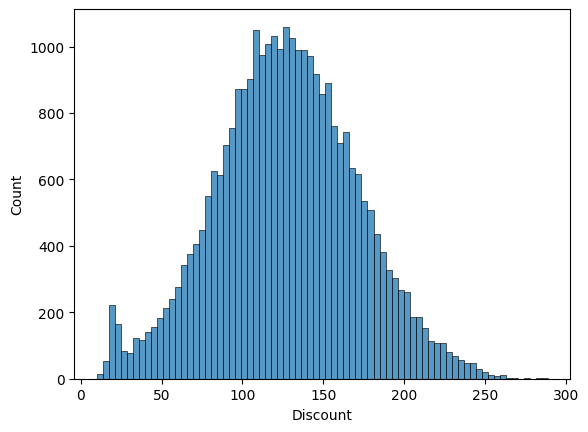

In [6]:
Clients = pd.DataFrame( promo_oct.groupby('ClientUUId')['Discount'].mean() )
# средняя скидка на клиента
seaborn.histplot ( promo_oct.groupby('ClientUUId')['Discount'].mean() )

<Axes: xlabel='OrderPrice', ylabel='Count'>

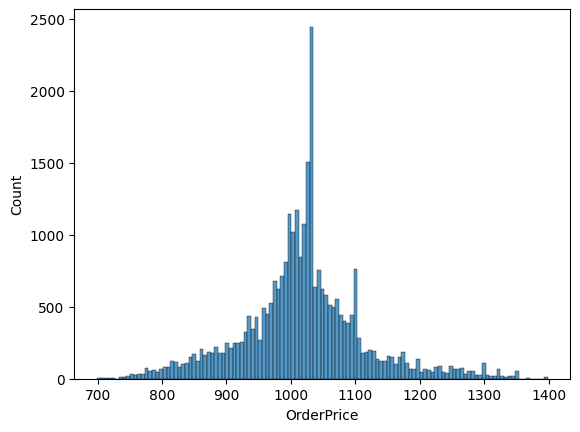

In [7]:
# средняя цена заказа на клиента
seaborn.histplot ( promo_oct.groupby('ClientUUId')['OrderPrice'].mean() )

In [8]:
Clients

Discount
ClientUUId                                  
000D3A20F23EA95811E7B699F64188B3  168.571429
000D3A20F23EA95811E7B7104AC23CD3  107.857143
000D3A20F23EA95811E7B7D79FAABAA1  227.222222
000D3A20F23EA95811E7B88F5E50100B  119.687500
000D3A20F23EA95811E7B8BD71C73877  145.000000
...                                      ...
FEE611D04A50BE1A11ED390682517C35   55.000000
FEEF35D36F3A978511EE57FC6EBC55EC   21.250000
FEEF35D36F3AA2A411EE57D13C7D60E7  102.857143
FEEF4D137BE19C9B11ED68BADE679AA2  115.277778
FEEF4D137BE1A5F411ED67F7B687A2AE  140.312500

[30000 rows x 1 columns]

## Orders

In [9]:
orders = pd.read_csv("data/orders.csv")
clients_o = set(orders['ClientUUId'].unique())   # клиенты из таблицы заказов
orders
orders['day'] = pd.to_datetime(orders['Date']).dt.day
orders['dayofyear'] = pd.to_datetime(orders['Date']).dt.dayofyear
orders['dayofweek'] = pd.to_datetime(orders['Date']).dt.dayofweek

In [10]:


# todo: вычислить средний период между заказами; это может быть как-то связано с периодом промо

In [11]:
# топ ProductUUId c которыми была применена акция
freqs = orders[orders['apply_promo'] == 1]['ProductUUId'].value_counts()
freqs.head(20)

ProductUUId
11EBADD5B90B8B4F0F2EF40F4E6B5B70    7442
000D3A240C71BE9A11E719BE2AB2D427    5503
000D3A240C71BE9A11E719BE2AB264A6    5335
11EBADD4B90B8B4F0F2EF40F8BDAB3D0    2566
11EB09F79A54C102242B4DFB907FF890    2495
11ECC9D29BACC18D6DC677D4F09E15D0    2358
11ED276CA17B3D3016833EF686833390    1935
000D3A240C71BE9A11E719BE2AD0E8CB    1860
000D3A24D2B7A94311E8AF7D16D63A0E    1851
000D3A240C71BE9A11E719BE2AB267FD    1662
11EA967A8F700D18CE3F8349CA7BF800    1584
11EBD7CBB197030BCEAF66C652D62170    1523
11ED543686D6E97413252BAB1915CE20    1509
11EBA76F916FDD8F3DE781D165D15C40    1423
11EBD7CAB197030BCEAF66C624E40120    1392
000D3A24D2B7A94311E857AF49FDC657    1358
000D3A39D824A82E11E9A18231161F85    1330
11EC06F1840C91B9A710D1135A5AFC40    1271
11ED42EDB34E05E6A7ADD5455FB01110    1253
11EBADD3B90B8B4F0F2EF40F26029420    1139
Name: count, dtype: int64

In [12]:
# топ ProductUUId c которыми была применена акция
freqs = orders[orders['apply_promo'] == 0]['ProductUUId'].value_counts()
freqs.head(20)

ProductUUId
000D3A240C71BE9A11E719BE2AB2D427    32556
11EBADD5B90B8B4F0F2EF40F4E6B5B70    27984
000D3A240C71BE9A11E719BE2AB264A6    21353
11ED276CA17B3D3016833EF686833390    10118
11EA967A8F700D18CE3F8349CA7BF800     9796
000D3A39D824A82E11E9A18231161F85     9647
11ECC9D29BACC18D6DC677D4F09E15D0     9612
11EB09F79A54C102242B4DFB907FF890     9335
11EBADD4B90B8B4F0F2EF40F8BDAB3D0     8808
000D3A240C71BE9A11E719BE2AB267FD     8298
000D3A24D2B7A94311E857AF49FDC657     7514
11ED34C9B728478196F532850FC1E6B0     7480
11EC06F1840C91B9A710D1135A5AFC40     7340
000D3A240C71BE9A11E719BE2AD0E8CB     7070
000D3A240C71BE9A11E719BE2AB1F41E     7036
000D3A39D824A82E11E9A18231161F87     7022
11ED543686D6E97413252BAB1915CE20     6888
11EBADD3B90B8B4F0F2EF40F26029420     6599
11EB2EF1A0F1FB35FE0B4C13BC2501B0     6143
11EBD7CBB197030BCEAF66C652D62170     5948
Name: count, dtype: int64

In [13]:
# топ ProductUUId c которыми была применена акция
freqs = orders[orders['apply_promo'] == 1]['UnitUUId'].value_counts()
freqs

UnitUUId
000D3A23B0DC80DC11E73C8C2B16F239    724
000D3A2C5B29A94711E807F6E8382B35    567
000D3A240C719A8711E68ABA13F97188    522
000D3A38B306A94411E8924C02E134A4    469
000D3A24D2B7A94311E8814F753A4858    455
                                   ... 
C260520EBBCB9B0D11EDF3C2DC2AAE26      5
000D3ABF84C3BB2E11EC3589DB7CC68E      4
000D3A240C719A8711E68ABA13F91E4B      4
5E928E9D6E51929F11EE2F76C6618CA5      3
F6D6338EA8029D4611EE09674D745734      2
Name: count, Length: 775, dtype: int64

In [14]:
len(orders['UnitUUId'].unique())   # 784

# топ ProductUUId c которыми была применена акция
freqs = orders[orders['apply_promo'] == 0]['UnitUUId'].value_counts()
freqs

UnitUUId
000D3A240C719A8711E68ABA13F860BF    3183
000D3A240C719A8711E68ABA13F83099    2928
000D3A2480C380F711E7AD98AF06953B    2314
000D3A26B5B080DD11E6C6B94301844F    2253
000D3A240C719A8711E68ABA13F8B2DF    2238
                                    ... 
867937076EF5BF2511ED3030B0403481      11
665AD9814FC4B47E11EE248143DFB30E       8
000D3A29FF6BA94511E8C5700642243E       7
000D3A29FF6BA94311E88F0F97B90D67       5
000D3A21DA51A81311EA4CB10382C74C       3
Name: count, Length: 784, dtype: int64

In [15]:
encoder_produuid = LabelEncoder()
orders['ProductUUId_int'] = encoder_produuid.fit_transform(orders['ProductUUId'])

In [16]:
orders.describe()

addressId  deliverySectorId      NewClient  ClientOrderNumber  \
count  4.883250e+05     488325.000000  611739.000000      611739.000000   
mean   2.964650e+05         81.843000       0.000656          51.259145   
std    1.970507e+06        588.142806       0.025595          49.811780   
min    0.000000e+00          0.000000       0.000000           1.000000   
25%    0.000000e+00          0.000000       0.000000          21.000000   
50%    0.000000e+00          0.000000       0.000000          38.000000   
75%    0.000000e+00          0.000000       0.000000          65.000000   
max    1.809518e+07       6798.000000       1.000000        1845.000000   

          CategoryId  ProductTotalPrice      MenuPrice     OrderState  \
count  611739.000000      611739.000000  611739.000000  611739.000000   
mean        2.938350         232.922882     284.286601       4.095296   
std         1.713509         234.839101     257.768164       0.811165   
min         1.000000           0.000000       0.000000       4.000000   
25%         1.000000          36.000000     109.000000       4.000000   
50%         3.000000         169.000000     199.000000       4.000000   
75%         4.000000         359.000000     419.000000       4.000000   
max         7.000000        1999.000000    2199.000000      11.000000   

       OrderPaymentType  OrderTotalPrice      OrderType    apply_promo  \
count     611739.000000    611739.000000  611739.000000  611739.000000   
mean           1.829803      1150.672311       1.402284       0.187686   
std            0.530010      2040.545692       0.800804       0.390462   
min            0.000000         0.000000       1.000000       0.000000   
25%            2.000000       661.000000       1.000000       0.000000   
50%            2.000000       959.000000       1.000000       0.000000   
75%            2.000000      1344.000000       1.000000       0.000000   
max            2.000000     99418.000000       3.000000       1.000000   

                 day      dayofyear      dayofweek  ProductUUId_int  
count  611739.000000  611739.000000  611739.000000    611739.000000  
mean       16.464446     229.868833       3.299600       179.316831  
std         8.824814      56.101331       1.983166       111.605960  
min         1.000000      74.000000       0.000000         0.000000  
25%         9.000000     195.000000       2.000000        72.000000  
50%        17.000000     243.000000       4.000000       178.000000  
75%        24.000000     276.000000       5.000000       264.000000  
max        31.000000     304.000000       6.000000       506.000000

In [17]:
orders['SaleDate'].min()

'2023-03-15T15:26:51.000Z'

In [18]:
# for col in ['CategoryId', 'ProductTotalPrice', 'MenuPrice', 'OrderState', 'OrderPaymentType', 'OrderTotalPrice', 'OrderType']:
#     plt.figure( figsize=(10, 3))
#     seaborn.histplot( orders[col] ); plt.show()

In [19]:
encoder_catid = LabelBinarizer()
orders[['cat1','cat2','cat3','cat4','cat5','cat6','cat7']] = encoder_catid.fit_transform(orders['CategoryId'])

In [20]:
# encoder_produuid = LabelBinarizer()

# orders = orders.join(pd.DataFrame(encoder_produuid.fit_transform(orders['ProductUUId']),
#                           columns=encoder_produuid.classes_, 
#                           index=orders.index))

# orders[['cat1','cat2','cat3','cat4','cat5','cat6','cat7']] = encoder_produuid.fit_transform(orders['ProductUUId'])

In [21]:
# тут всё крашится
# orders.drop(columns=['OrderUUId','ClientUUId','Date','SaleDate','UnitUUId','ProductUUId','ProductUUId']).corr().iloc[]

In [22]:
# plt.figure( figsize=(15,15) )
# seaborn.heatmap( orders.drop(columns=['OrderUUId','ClientUUId','Date','SaleDate','UnitUUId','ProductUUId','ProductUUId']).corr(), annot=True, cmap='coolwarm', fmt='.2f' )

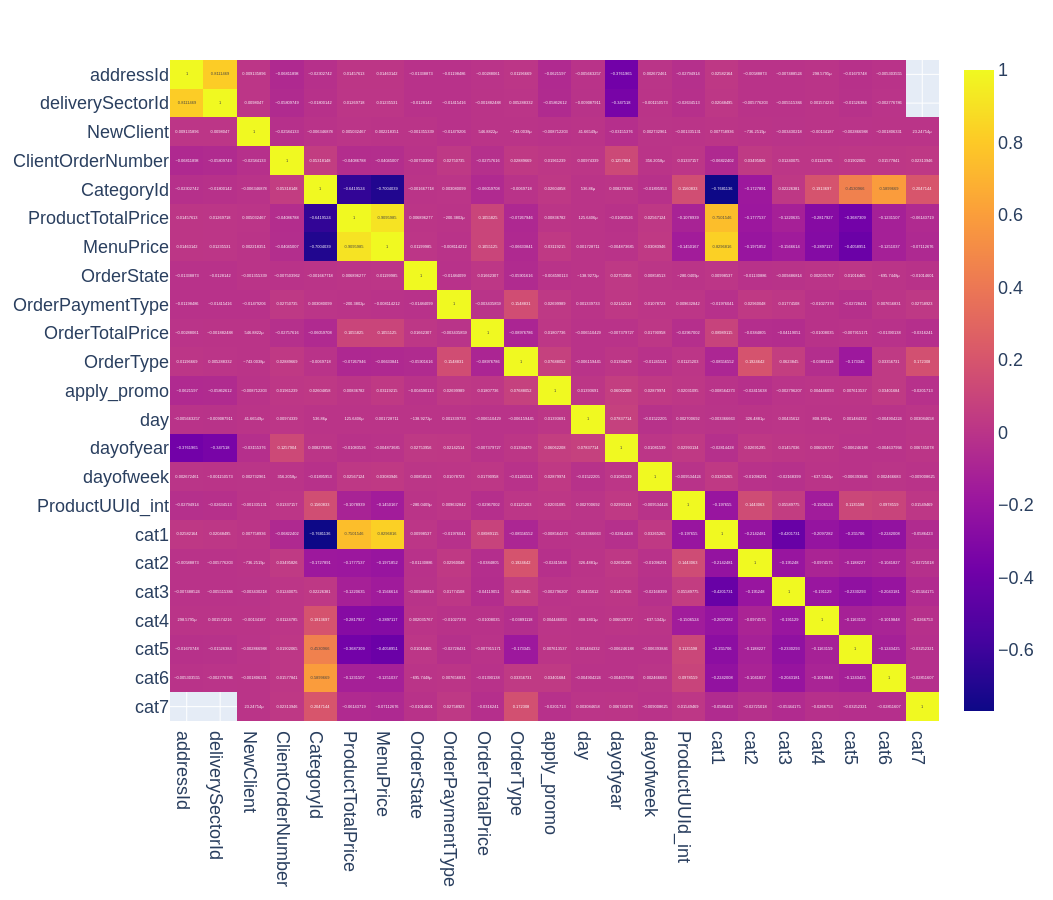

In [23]:
import plotly.express as px



fig = px.imshow( orders.drop(columns=['OrderUUId','ClientUUId','Date','SaleDate','UnitUUId','ProductUUId','ProductUUId']).corr(), 
                text_auto=True, height=900, aspect="auto")
# fig.update_layout(
#     font=dict(
#         family="Courier New, monospace",
#         size=18,  # Set the font size here
#         color="RebeccaPurple"
#     )
# )
# fig.update_traces(textposition='inside', textfont_size=14)
fig['layout']['font']['size'] = 18
fig.show()

### Новые признаки

In [24]:
orders['Order_Oct'] = orders['Date'] > '2023-10-01'
orders['Order_Oct_last10'] = orders['Date'] > '2023-10-21'
orders['Order_Oct_last5']  = orders['Date']> '2023-10-24'
orders['Order_Oct_last1']  = orders['Date']> '2023-10-30'

In [25]:
# кодичество заказов на человека
MaxOrderByClient = orders.groupby("ClientUUId")['ClientOrderNumber'].max()
Clients = pd.DataFrame( {"ClientUUId":MaxOrderByClient.index, "Order_counts":MaxOrderByClient.values} )

# средняя цена продукта в заказе
MeanPriceByClient = orders.groupby("ClientUUId")['ProductTotalPrice'].mean()
Clients['MeanProductPrice'] = MeanPriceByClient.values

# средняя стоимость заказа
MeanTotalPriceByClient = orders.groupby("ClientUUId")['OrderTotalPrice'].mean()
Clients['MeanOrderPrice'] = MeanTotalPriceByClient.values

# минимальная цена заказа. Иногда бывает 1. 
MinOrderPriceByClient = orders.groupby("ClientUUId")['OrderTotalPrice'].min()
Clients['MinOrderPriceByClient'] = MinOrderPriceByClient.values

# макс цена заказа. 
MinOrderPriceByClient = orders.groupby("ClientUUId")['OrderTotalPrice'].max()
Clients['MaxOrderPriceByClient'] = MinOrderPriceByClient.values

# сколько раз применял промокод?
PromoCountByClient = orders.groupby("ClientUUId")['apply_promo'].sum()
Clients['PromoCount'] = PromoCountByClient.values

# промокоды / заказы ( + )
Clients['PromoPerOrder'] = Clients['PromoCount']/Clients['Order_counts']

# средний тип заказа
MeanOrderTypeByClient = orders.groupby("ClientUUId")['OrderType'].sum()
Clients['MeanOrderTypeByClient'] = MeanOrderTypeByClient.values

# средний номер дня в году??
# MeanDoYByClient = orders.groupby("ClientUUId")['dayofyear'].mean()
# Clients['MeanDoYByClient'] = MeanDoYByClient.values

# средний номер дня в неделе?? - -
# MeanDoWByClient = orders.groupby("ClientUUId")['dayofweek'].mean()
# Clients['MeanDoWByClient'] = MeanDoWByClient.values

# средний номер дня в неделе?? - - 
# StdDoWByClient = orders.groupby("ClientUUId")['dayofweek'].std()
# Clients['StdDoWByClient'] = StdDoWByClient.values

# количество секторов доставки доставки на клиента
SectorsByClient = orders.groupby("ClientUUId")['deliverySectorId'].count()
Clients['SectorsByClient'] = SectorsByClient.values


# количество адресов доставки на клиента
AddressesByClient = orders.groupby("ClientUUId")['addressId'].count()
Clients['AddressesByClient'] = AddressesByClient.values


AddressesByClient = orders.groupby("ClientUUId")['addressId'].count()
Clients['MeanCatIdByClient'] = AddressesByClient.values

# есть заказы категорий (-,-)
# есть заказы категории
# Cat2ByClient = orders.groupby("ClientUUId")['cat6'].count()
# Clients['Cat2ByClient'] = Cat2ByClient.values

# # есть заказы категории
# Cat6ByClient = orders.groupby("ClientUUId")['cat6'].count()
# Clients['Cat6ByClient'] = Cat6ByClient.values

# # есть заказы категории
# Cat7ByClient = orders.groupby("ClientUUId")['cat7'].count()
# Clients['Cat7ByClient'] = Cat7ByClient.values


# использовать индетификаторы товаров? (+,+)
_ = orders.groupby("ClientUUId")['ProductUUId'].agg( lambda x: "000D3A24D2B7A94311E8AF7D16D63A0E" == x).apply(sum)
Clients['has_prod1'] = _.values

# (-,-)
# _ = orders.groupby("ClientUUId")['ProductUUId'].agg( lambda x: "11EBA76F916FDD8F3DE781D165D15C40" == x).apply(sum)
# Clients['has_prod2'] = _.values

# 11EBD7CAB197030BCEAF66C624E40120    1392+
# 11ED42EDB34E05E6A7ADD5455FB01110    1253+


# BonusActByClient = events.groupby("ClientUUId")['EventName'].agg( lambda x: "open_bonusaction" == x).apply(sum)
# ClientsEvents['BonusActByClient'] = BonusActByClient.values


# дата последнего заказа  ( тест +, сайт - )
# LatsOrderDateByClient = orders.groupby("ClientUUId")['Date'].max()
# Clients['LatsOrderDateByClient'] = pd.to_datetime( LatsOrderDateByClient.values).values.astype(np.int64)

# Количество заказов в октябре  ( - )
# OctOrdersByClient = orders.groupby("ClientUUId")['Order_Oct'].sum()
# Clients['OctOrdersByClient'] = pd.to_datetime( OctOrdersByClient.values).values.astype(np.int64)

# всё, что ниже ухудшило тест
# Количество заказов в последние 10 дней октября  ( - )
# OctLast10OrdersByClient = orders.groupby("ClientUUId")['Order_Oct_last10'].sum()
# Clients['OctLast10OrdersByClient'] = OctLast10OrdersByClient.values

# Количество заказов в последние 5 дней октября  ( - )
# OctLast5OrdersByClient = orders.groupby("ClientUUId")['Order_Oct_last5'].sum()
# Clients['OctLast5OrdersByClient'] = OctLast5OrdersByClient.values

# Количество заказов в последние 1 дней октября  ( - )
# OctLast1OrdersByClient = orders.groupby("ClientUUId")['Order_Oct_last1'].sum()
# Clients['OctLast1OrdersByClient'] = OctLast1OrdersByClient.values

Clients

# toto: частота заказов

ClientUUId  Order_counts  MeanProductPrice  \
0      000D3A20F23EA95811E7B7104AC23CD3           151        149.743243   
1      000D3A20F23EA95811E7B88F5E50100B            66        173.557692   
2      000D3A20F23EA95811E7B8BD71C73877           121        245.000000   
3      000D3A20F23EA95811E7B95FE7E6321C            96        174.020833   
4      000D3A20F23EA95811E7B969B5BD2C3F           116        330.176471   
...                                 ...           ...               ...   
16332  FEDF5AD2CE2EA90211ED506C43F7C986            32        163.041667   
16333  FEE22A126ECA916311ECF33D671B594D            15        163.716418   
16334  FEE611D04A50966311ED36EFD083D176            30        244.511111   
16335  FEE611D04A50BE1A11ED390682517C35            33        201.571429   
16336  FEEF4D137BE1A5F411ED67F7B687A2AE            23        212.772727   

       MeanOrderPrice  MinOrderPriceByClient  MaxOrderPriceByClient  \
0         1139.810811                  823.0                 1565.0   
1         1150.288462                  524.0                 1708.0   
2          945.600000                  130.0                 1523.0   
3          904.229167                    0.0                 1378.0   
4         1170.529412                  231.0                 1645.0   
...               ...                    ...                    ...   
16332      520.291667                    1.0                 1449.0   
16333     1167.611940                  508.0                 1829.0   
16334     1224.733333                  179.0                 2133.0   
16335      606.285714                    0.0                  864.0   
16336      562.590909                  169.0                  773.0   

       PromoCount  PromoPerOrder  MeanOrderTypeByClient  SectorsByClient  \
0              62       0.410596                     74               74   
1               6       0.090909                     52               52   
2               5       0.041322                     35               35   
3               5       0.052083                     50               47   
4               0       0.000000                     60               21   
...           ...            ...                    ...              ...   
16332           3       0.093750                     64                4   
16333          43       2.866667                    137               32   
16334           0       0.000000                    113               11   
16335          13       0.393939                     36               24   
16336           0       0.000000                     62                2   

       AddressesByClient  MeanCatIdByClient  has_prod1  
0                     74                 74          2  
1                     52                 52          0  
2                     35                 35          0  
3                     47                 47          0  
4                     21                 21          0  
...                  ...                ...        ...  
16332                  4                  4          0  
16333                 32                 32          0  
16334                 11                 11          0  
16335                 24                 24          0  
16336                  2                  2          1  

[16337 rows x 13 columns]

In [26]:
Clients.describe()

Order_counts  MeanProductPrice  MeanOrderPrice  MinOrderPriceByClient  \
count  16337.000000      16337.000000    16337.000000           16337.000000   
mean      55.208912        256.015333     1020.136787             394.821509   
std       51.903689        116.069621      858.861611             324.044323   
min       10.000000          0.000000        0.000000               0.000000   
25%       25.000000        173.717391      718.756757              99.000000   
50%       41.000000        228.433333      933.200000             380.000000   
75%       68.000000        308.944444     1203.813953             612.000000   
max     1845.000000       1111.285714    89704.430328            2619.000000   

       MaxOrderPriceByClient    PromoCount  PromoPerOrder  \
count           16337.000000  16337.000000   16337.000000   
mean             1633.779886      7.027912       0.191632   
std              1220.726092     10.732938       0.360474   
min                 0.000000      0.000000       0.000000   
25%              1080.000000      0.000000       0.000000   
50%              1416.000000      3.000000       0.045455   
75%              1906.000000     10.000000       0.241379   
max             99418.000000    169.000000       5.153846   

       MeanOrderTypeByClient  SectorsByClient  AddressesByClient  \
count           16337.000000     16337.000000       16337.000000   
mean               52.508539        29.890739          29.890739   
std                26.170513        20.933603          20.933603   
min                 4.000000         0.000000           0.000000   
25%                35.000000        15.000000          15.000000   
50%                47.000000        28.000000          28.000000   
75%                65.000000        42.000000          42.000000   
max               261.000000       244.000000         244.000000   

       MeanCatIdByClient     has_prod1  
count       16337.000000  16337.000000  
mean           29.890739      0.359980  
std            20.933603      1.178019  
min             0.000000      0.000000  
25%            15.000000      0.000000  
50%            28.000000      0.000000  
75%            42.000000      0.000000  
max           244.000000     21.000000

<Axes: >

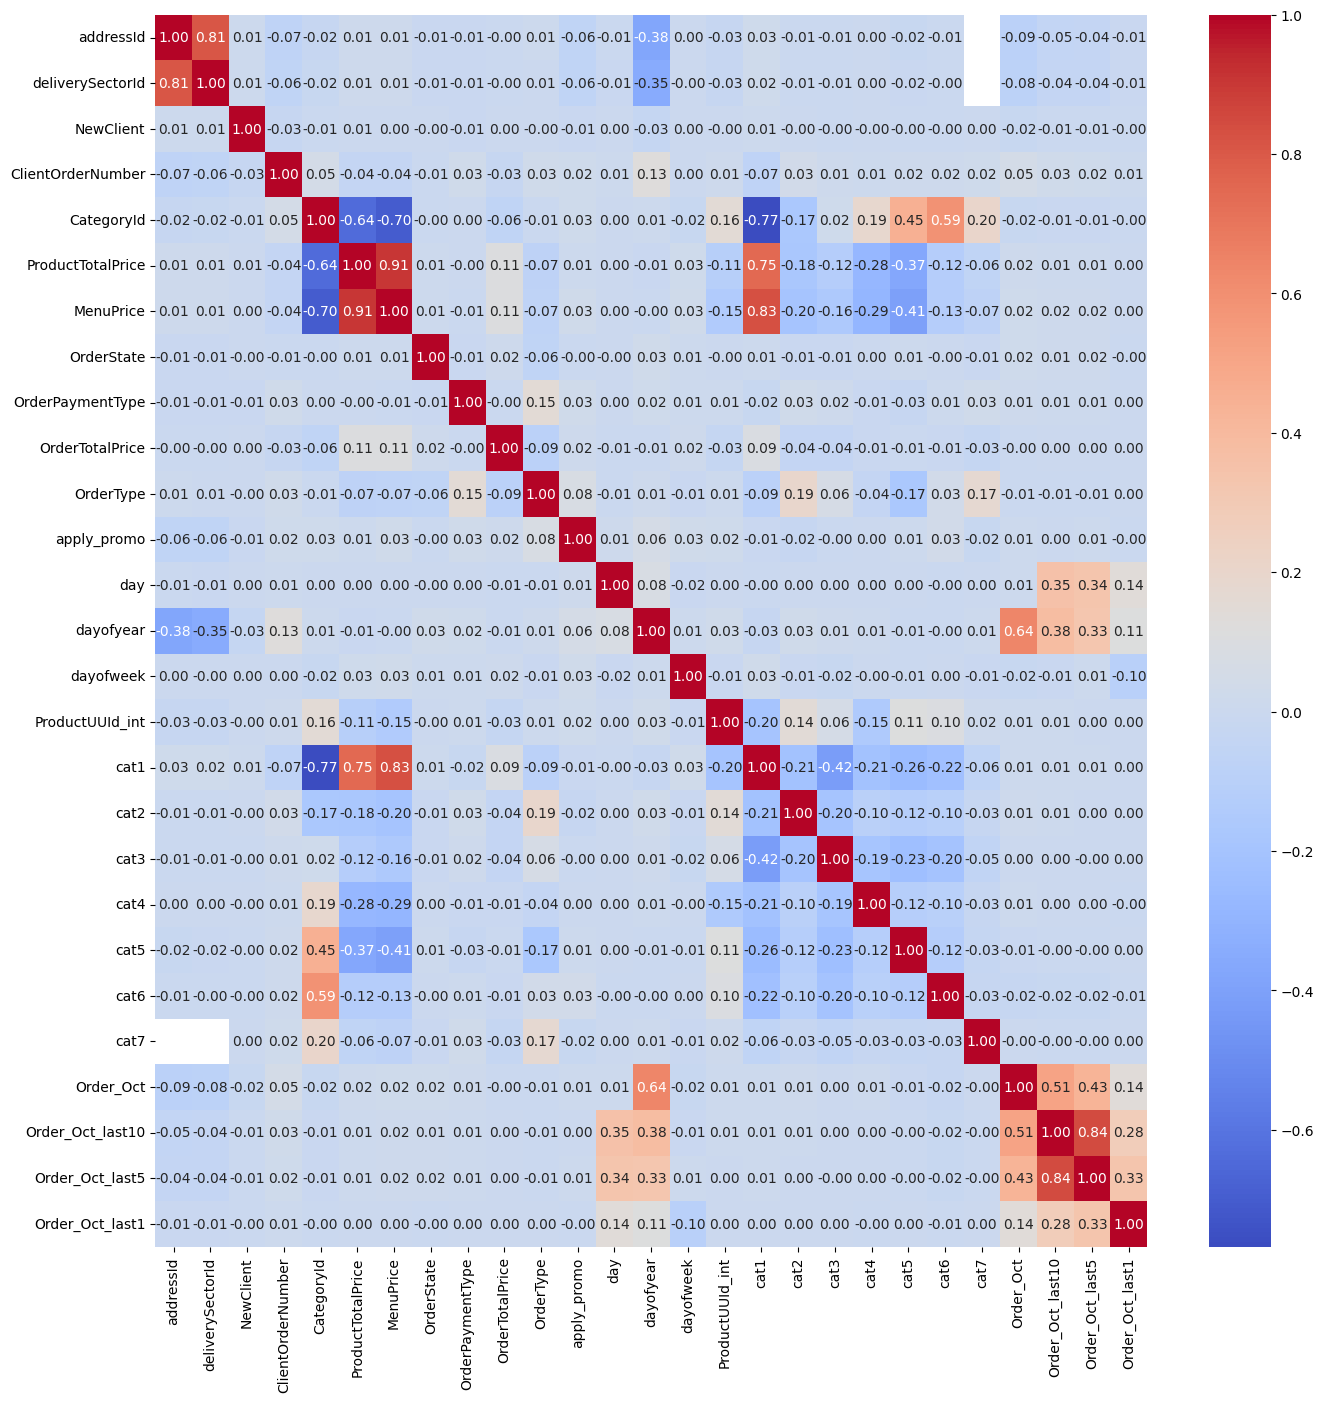

In [27]:
plt.figure( figsize=(16,16) )
seaborn.heatmap( orders.drop(columns=['Date','SaleDate','OrderUUId','ClientUUId','ProductUUId','UnitUUId']).corr(), 
                annot=True, cmap='coolwarm', fmt="0.2f" )

## Events

In [28]:
events = pd.read_csv("data/mobile_events.csv")
clients_e = set(events['ClientUUId'].unique())   # клиенты из таблицы заказов
events

ClientUUId  \
0        000D3A22FA54A81611EB315CF5443815   
1        2A4A64AF719E994511EE3F2D8B31E188   
2        000D3AAC977BBB2F11ECDD081F5481AE   
3        000D3A21DA51A81411EAE468856F96F1   
4        000D3A23B0DC80D811E67F4D0A9CA345   
...                                   ...   
3916649  000D3A25D54580E011E707D4762E0C84   
3916650  CEA31E584572ADD411ED0E4D10ED070E   
3916651  000D3A25D54580E011E707D4762E0C84   
3916652  CEA31E584572ADD411ED0E4D10ED070E   
3916653  000D3A25D54580E011E707D4762E0C84   

                                   VisitToken       EventName Platform  \
0        976627AD-76DC-41D9-981E-F2A6CA14B3A9     screen_menu      ios   
1        5b22e610-c71e-4b6a-a842-71e8575ece87     screen_menu  android   
2        BDCEB72F-2B6A-4565-801A-6CB729279C6F        open_app      ios   
3        A66E2DA6-4E2E-4C37-9FBF-627732623212     add_to_cart      ios   
4        1BE8139F-A3D3-439F-A51B-5CBD4D3FFF1B     screen_menu      ios   
...                                       ...             ...      ...   
3916649  C5EC0144-6C3C-45C2-B0A4-A7A2B6B45444        open_app      ios   
3916650  5a8b6b6c-e4ad-4fd9-aad9-895fa987ddf1  screen_profile  android   
3916651  C5EC0144-6C3C-45C2-B0A4-A7A2B6B45444       close_app      ios   
3916652  5a8b6b6c-e4ad-4fd9-aad9-895fa987ddf1     screen_menu  android   
3916653  C5EC0144-6C3C-45C2-B0A4-A7A2B6B45444       close_app      ios   

                            Timestamp  
0            2023-10-29T16:14:21.343Z  
1        2023-10-29T11:04:36.4840000Z  
2            2023-10-29T11:14:34.723Z  
3            2023-10-29T14:03:08.363Z  
4            2023-10-29T08:35:40.127Z  
...                               ...  
3916649      2023-10-14T06:00:21.558Z  
3916650  2023-10-13T12:55:57.7520000Z  
3916651      2023-10-14T06:00:21.515Z  
3916652  2023-10-13T12:55:56.3030000Z  
3916653      2023-10-14T06:00:21.558Z  

[3916654 rows x 5 columns]

In [29]:
# количество событий на человека ( test+, site+ )
EventCountByClient = events.groupby("ClientUUId")['EventName'].count()
ClientsEvents = pd.DataFrame( {"ClientUUId":EventCountByClient.index, "EventCountByClient":EventCountByClient.values} )


# кодичество VisitToken на человека ( test-, site+ )
VisitsByClient = events.groupby("ClientUUId")['VisitToken'].nunique()
ClientsEvents['VisitsByClient'] = VisitsByClient.values

# среднее количество событий на визит
ClientsEvents['MeanVisitEventsByClient'] = ClientsEvents['EventCountByClient']/ClientsEvents['VisitsByClient']

# конкретные события
ScrMenuByClient = events.groupby("ClientUUId")['EventName'].agg( lambda x: "screen_menu" == x).apply(sum)
ClientsEvents['ScrMenuByClient'] = ScrMenuByClient.values

#
# конкретные события
# ScrMenuByClient = events.groupby("ClientUUId")['EventName'].agg( lambda x: "open_app" == x).apply(sum)
# ClientsEvents['ScrMenuByClient'] = ScrMenuByClient.values

# # конкретные события
# (-,-)
# ScrProfileByClient = events.groupby("ClientUUId")['EventName'].agg( lambda x: "screen_profile" == x).apply(sum)
# ClientsEvents['ScrProfileByClient'] = ScrProfileByClient.values


# # конкретные события
# ScrMenuByClient = events.groupby("ClientUUId")['EventName'].agg( lambda x: "screen_cart" == x).apply(sum)
# ClientsEvents['ScrMenuByClient'] = ScrMenuByClient.values


# # конкретные события
# ScrMenuByClient = events.groupby("ClientUUId")['EventName'].agg( lambda x: "open_product_card" == x).apply(sum)
# ClientsEvents['ScrMenuByClient'] = ScrMenuByClient.values

# (+, +)
BonusActByClient = events.groupby("ClientUUId")['EventName'].agg( lambda x: "open_bonusaction" == x).apply(sum)
ClientsEvents['BonusActByClient'] = BonusActByClient.values


# (+, +)
ApplyOfferByClient = events.groupby("ClientUUId")['EventName'].agg( lambda x: "apply_personal_offer" == x).apply(sum)
ClientsEvents['ApplyOfferByClient'] = ApplyOfferByClient.values

RemFrCartByClient = events.groupby("ClientUUId")['EventName'].agg( lambda x: "remove_from_cart" == x).apply(sum)
ClientsEvents['RemFrCartByClient'] = RemFrCartByClient.values

In [30]:
events[events['EventName'] == "screen_menu"].groupby("ClientUUId").count()
VisitsByClient

ClientUUId
000D3A20F23EA95811E7B699F64188B3     9
000D3A20F23EA95811E7B7104AC23CD3    13
000D3A20F23EA95811E7B7D79FAABAA1     3
000D3A20F23EA95811E7B88F5E50100B    10
000D3A20F23EA95811E7B8BD71C73877     9
                                    ..
FEE611D04A50BE1A11ED390682517C35    43
FEEF35D36F3A978511EE57FC6EBC55EC    12
FEEF35D36F3AA2A411EE57D13C7D60E7    11
FEEF4D137BE19C9B11ED68BADE679AA2     2
FEEF4D137BE1A5F411ED67F7B687A2AE    10
Name: VisitToken, Length: 29838, dtype: int64

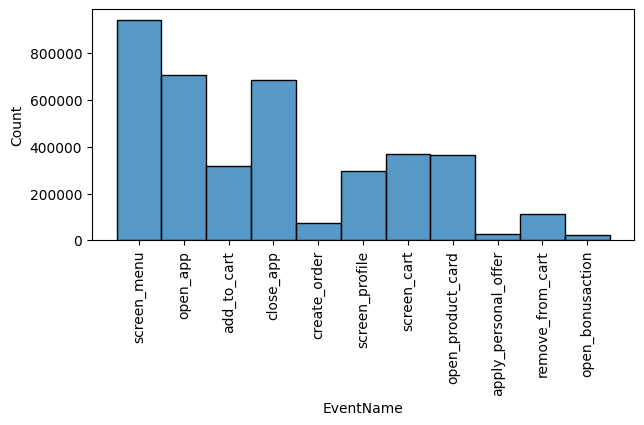

In [31]:
plt.figure( figsize=(7,3) )
seaborn.histplot( events['EventName'], discrete=True)
plt.xticks(rotation=90)
plt.show()

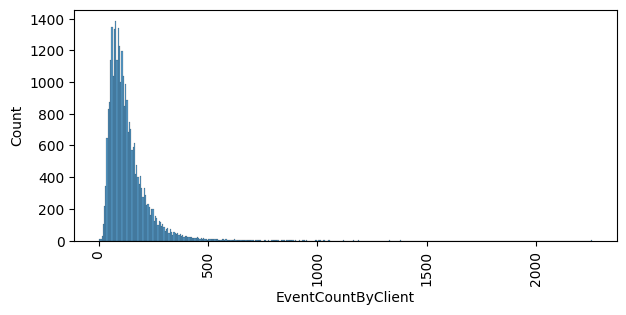

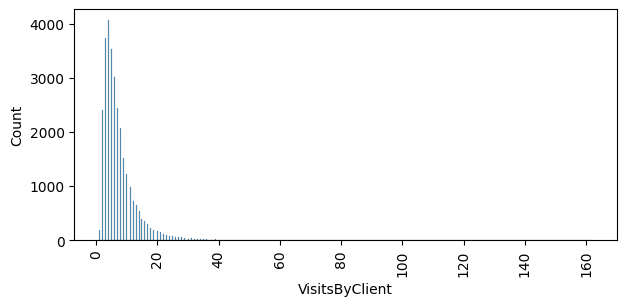

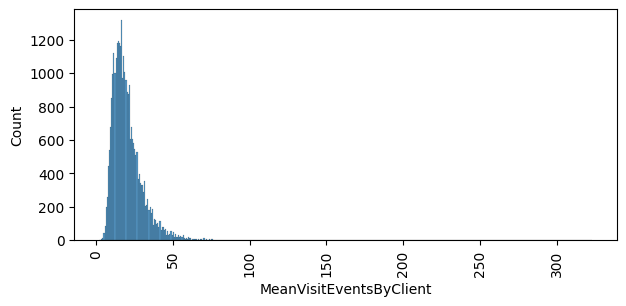

In [32]:
plt.figure( figsize=(7,3) )
seaborn.histplot( ClientsEvents['EventCountByClient'])
plt.xticks(rotation=90)
plt.show()

plt.figure( figsize=(7,3) )
seaborn.histplot( ClientsEvents['VisitsByClient'])
plt.xticks(rotation=90)
plt.show()

plt.figure( figsize=(7,3) )
seaborn.histplot( ClientsEvents['MeanVisitEventsByClient'])
plt.xticks(rotation=90)
plt.show()

## Train

In [33]:
train = pd.read_csv("data/train_target.csv")
clients_tr = set(train['ClientUUId'].unique())   # клиенты из таблицы трейна
train

ClientUUId  Id OrderType  \
0      000D3A20F23EA95811E7B99F3ED09FC8   7       2,3   
1      000D3A20F23EA95811E7B99F3ED09FC8   6     1,2,3   
2      000D3A20F23EA95811E7BD373E79565E   5       2,3   
3      000D3A20F23EA95811E7BD373E79565E   5     1,2,3   
4      000D3A20F23EA95811E7BDAE71CD3F33   6       2,3   
...                                 ...  ..       ...   
27736  82EDBCD6CE60978F11EDC591DCA75401   5       2,3   
27737  82EDBCD6CE60978F11EDC591DCA75401   5     1,2,3   
27738  82F78FC7401A9ADD11EDFA15A350D31F   6       2,3   
27739  8606F5E4CA39BF7211EE517E6E1D90B7   5       2,3   
27740  8606F5E4CA39BF7211EE517E6E1D90B7   5     1,2,3   

                 LocalBeginDate              LocalEndDate  OrderPrice  \
0      2023-11-02T00:00:00.000Z  2023-11-05T23:59:00.000Z         699   
1      2023-11-02T00:00:00.000Z  2023-11-05T23:59:00.000Z        1249   
2      2023-11-02T00:00:00.000Z  2023-11-05T23:59:00.000Z         799   
3      2023-11-02T00:00:00.000Z  2023-11-05T23:59:00.000Z        1249   
4      2023-11-02T00:00:00.000Z  2023-11-05T23:59:00.000Z         699   
...                         ...                       ...         ...   
27736  2023-11-02T00:00:00.000Z  2023-11-05T23:59:00.000Z         799   
27737  2023-11-02T00:00:00.000Z  2023-11-05T23:59:00.000Z        1249   
27738  2023-11-02T00:00:00.000Z  2023-11-05T23:59:00.000Z         799   
27739  2023-11-02T00:00:00.000Z  2023-11-05T23:59:00.000Z         749   
27740  2023-11-02T00:00:00.000Z  2023-11-05T23:59:00.000Z        1249   

       Discount  apply_promo  
0           200            0  
1            25            0  
2           200            0  
3           250            0  
4            30            0  
...         ...          ...  
27736       200            0  
27737       250            0  
27738        20            0  
27739       200            0  
27740       250            0  

[27741 rows x 8 columns]

In [34]:
# клиенты из трейна и клиенты из таблицы с событиями
len( clients_tr.intersection( clients_e ) )

18493

In [35]:
# клиенты из трейна и клиенты из таблицы с выданными промо
len( clients_tr.intersection( clients_po ) )

18598

In [36]:
len(clients_tr.intersection( clients_o ))

10023

<Axes: xlabel='apply_promo', ylabel='Count'>

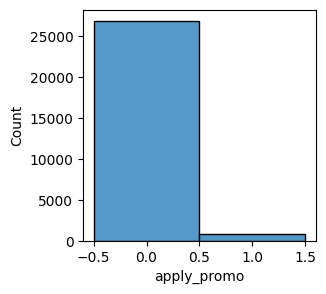

In [37]:
plt.figure( figsize=(3,3) )
seaborn.histplot( train["apply_promo"], discrete=True)

In [38]:
# train1['ClientUUId'].values

In [39]:
# train1['Id'].values.reshape(-1, 1).shape

In [40]:
def preprocess(df: pd.DataFrame, encoder_id:LabelBinarizer=None, has_promo:set=None, 
                   clients:pd.DataFrame=None, clients_events:pd.DataFrame = None):
    """Обработка данных трейна и теста
    has_promo - CLientUUId тех, кому хоть раз промо выдавали
    Clients - общая таблица с клеинтами"""
    df1 = df.drop(columns=['OrderType'])
    # df1['OrderType_1'] = df['OrderType'].apply( lambda s: int('1' in s))
    # df1['OrderType_2'] = df['OrderType'].apply( lambda s: int('2' in s))    # бесполезный признак = константа
    # df1['OrderType_3'] = df['OrderType'].apply( lambda s: int('3' in s))    # бесполезный признак = консттанта
    # цена со скидкой
    # df1['PriceWDisc'] = df1['OrderPrice'] - df1['Discount'] # ( - )
    df1['DiscPerc'] = df1['Discount'] / df1['OrderPrice']     # ( + )

    # df1['LocalBeginDate'] = pd.to_datetime(df1['LocalBeginDate']).astype(np.int64)
    # df1['LocalEndDate'] = pd.to_datetime(df1['LocalEndDate']).astype(np.int64) 
    # дата - это просто месяц, он не менеятся

    # new_cols = 

    # one_hot кодирование вредит
    # if encoder_id is None:
    #     encoder_id = LabelBinarizer()
    #     df1[['Id_5', 'Id_6', 'Id_7']] = encoder_id.fit_transform(df1['Id'])
    # else:
    #      df1[['Id_5', 'Id_6', 'Id_7']] = encoder_id.transform(df1['Id'])
    # df1 = df1.drop(columns=['Id'])  

    # бесполезный признак = консттанта
    # if has_promo:    
    #     df1['was_promo'] = df1['ClientUUId'].apply( lambda uuid: int(uuid in has_promo))
    # else:
    #     df1['was_promo'] = 0
  
    if clients is not None:
        df1 = df1.merge(clients, on='ClientUUId', how='left')

    if clients_events is not None:
        df1 = df1.merge(clients_events, on='ClientUUId', how='left')

    df1['EventCountByClient'] = np.log(df1['EventCountByClient'])
    df1['VisitsByClient'] = np.log(df1['VisitsByClient'])
    df1['MeanVisitEventsByClient'] = np.log(df1['MeanVisitEventsByClient'])
    
    df1 = df1.drop(columns=['OrderPrice'])
    df1 = df1.drop(columns=['ClientUUId','LocalBeginDate','LocalEndDate'])
    df1 = df1.fillna(0)
    return df1, encoder_id

# кодировать клиентов не стоит, т.к. в тесте их нет
# client_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder_id = None
train1, encoder_id = preprocess( train, has_promo = clients_po, clients=Clients, clients_events = ClientsEvents )
encoder_id
# encoder_id = LabelBinarizer()
# train[['Id_5', 'Id_6', 'Id_7']] = pd.DataFrame( encoder_id.fit_transform(train['Id']) )
# client_encoder.fit( train1['ClientUUId'].values.reshape(-1, 1) )
# train1['client_label'] = client_encoder.fit_transform( train1['ClientUUId'].values.reshape(-1, 1) )

In [41]:
train1

Id  Discount  apply_promo  DiscPerc  Order_counts  MeanProductPrice  \
0       7       200            0  0.286123         118.0        278.151515   
1       6        25            0  0.020016         118.0        278.151515   
2       5       200            0  0.250313           0.0          0.000000   
3       5       250            0  0.200160           0.0          0.000000   
4       6        30            0  0.042918           0.0          0.000000   
...    ..       ...          ...       ...           ...               ...   
27736   5       200            0  0.250313          13.0        315.904762   
27737   5       250            0  0.200160          13.0        315.904762   
27738   6        20            0  0.025031           0.0          0.000000   
27739   5       200            0  0.267023           0.0          0.000000   
27740   5       250            0  0.200160           0.0          0.000000   

       MeanOrderPrice  MinOrderPriceByClient  MaxOrderPriceByClient  \
0         1853.727273                   70.0                 5039.0   
1         1853.727273                   70.0                 5039.0   
2            0.000000                    0.0                    0.0   
3            0.000000                    0.0                    0.0   
4            0.000000                    0.0                    0.0   
...               ...                    ...                    ...   
27736     1443.595238                  210.0                 2053.0   
27737     1443.595238                  210.0                 2053.0   
27738        0.000000                    0.0                    0.0   
27739        0.000000                    0.0                    0.0   
27740        0.000000                    0.0                    0.0   

       PromoCount  ...  AddressesByClient  MeanCatIdByClient  has_prod1  \
0             0.0  ...               20.0               20.0        0.0   
1             0.0  ...               20.0               20.0        0.0   
2             0.0  ...                0.0                0.0        0.0   
3             0.0  ...                0.0                0.0        0.0   
4             0.0  ...                0.0                0.0        0.0   
...           ...  ...                ...                ...        ...   
27736        10.0  ...               19.0               19.0        0.0   
27737        10.0  ...               19.0               19.0        0.0   
27738         0.0  ...                0.0                0.0        0.0   
27739         0.0  ...                0.0                0.0        0.0   
27740         0.0  ...                0.0                0.0        0.0   

       EventCountByClient  VisitsByClient  MeanVisitEventsByClient  \
0                5.231109        3.218876                 2.012233   
1                5.231109        3.218876                 2.012233   
2                4.574711        1.609438                 2.965273   
3                4.574711        1.609438                 2.965273   
4                4.634729        1.386294                 3.248435   
...                   ...             ...                      ...   
27736            5.068904        1.386294                 3.682610   
27737            5.068904        1.386294                 3.682610   
27738            4.795791        1.791759                 3.004031   
27739            4.844187        1.791759                 3.052428   
27740            4.844187        1.791759                 3.052428   

       ScrMenuByClient  BonusActByClient  ApplyOfferByClient  \
0                 54.0               0.0                 0.0   
1                 54.0               0.0                 0.0   
2                 12.0               0.0                 0.0   
3                 12.0               0.0                 0.0   
4                 16.0               0.0                 0.0   
...                ...               ...                 ...   
27736             40.0     

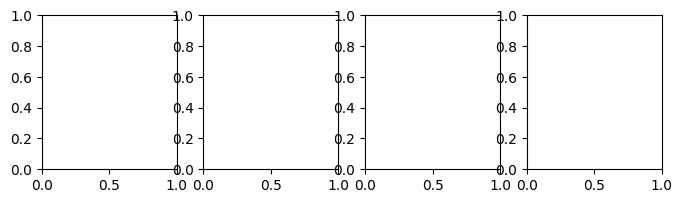

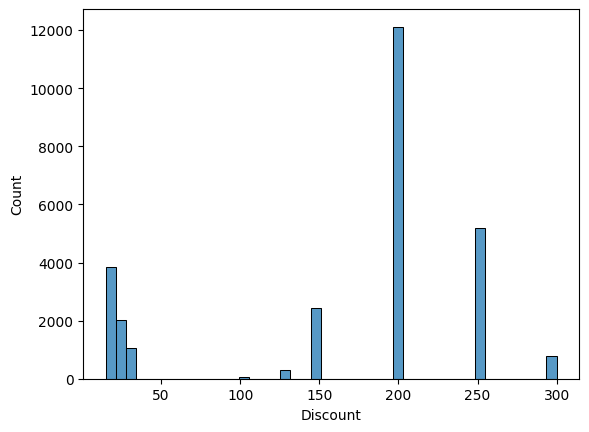

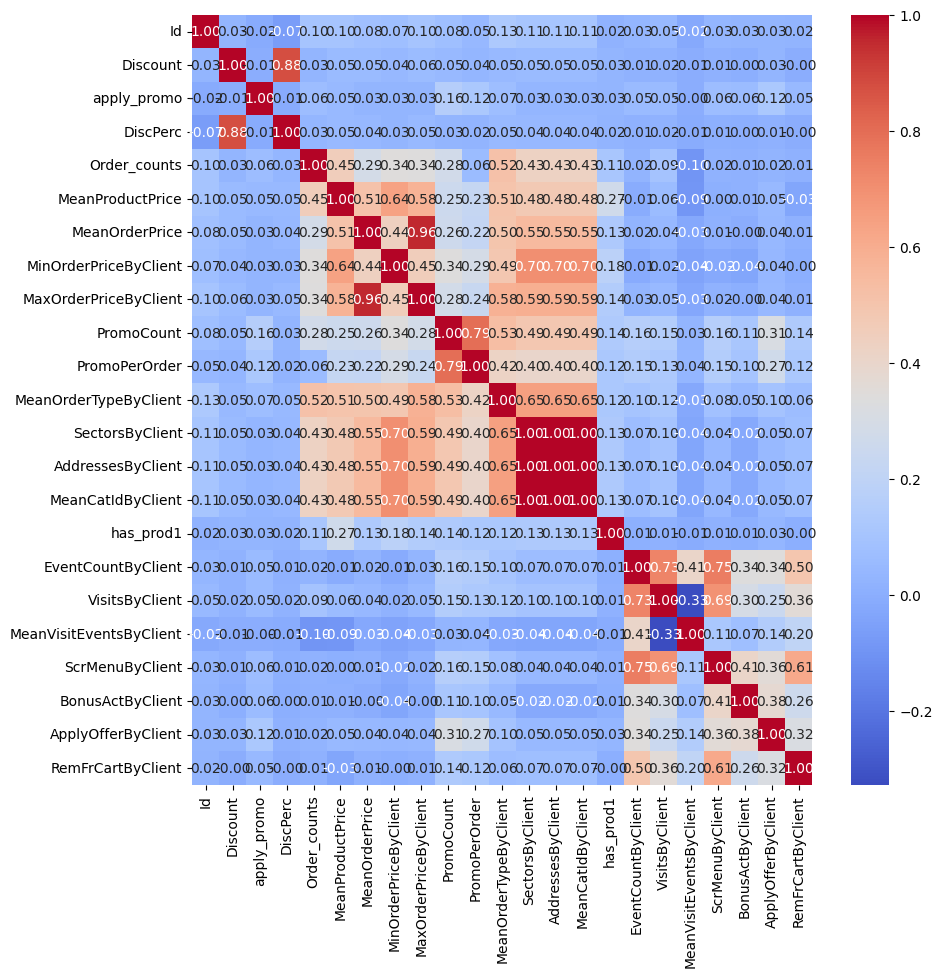

In [42]:
def plots(df: pd.DataFrame ):
    plt.subplots( 1,4, figsize=(8,2))
    plt.subplot( 1, 4, 1)
    # seaborn.histplot( df['OrderType_1'], discrete=True)
    
    # plt.subplot( 1, 4, 2)
    # seaborn.histplot( df['OrderType_2'], discrete=True)
    
    # plt.subplot( 1, 4, 3)
    # seaborn.histplot( df['OrderType_3'], discrete=True)
    
    # plt.subplot( 1, 4, 4)
    # seaborn.histplot( df['was_promo'], discrete=True)
    plt.show()

    # seaborn.histplot( df['OrderPrice'] ); plt.show()

    seaborn.histplot( df['Discount'] ); plt.show()

    plt.figure( figsize=(10,10) )
    seaborn.heatmap( df.corr(), annot=True, cmap='coolwarm', fmt='.2f' )


plots(train1)

In [43]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27741 entries, 0 to 27740
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       27741 non-null  int64  
 1   Discount                 27741 non-null  int64  
 2   apply_promo              27741 non-null  int64  
 3   DiscPerc                 27741 non-null  float64
 4   Order_counts             27741 non-null  float64
 5   MeanProductPrice         27741 non-null  float64
 6   MeanOrderPrice           27741 non-null  float64
 7   MinOrderPriceByClient    27741 non-null  float64
 8   MaxOrderPriceByClient    27741 non-null  float64
 9   PromoCount               27741 non-null  float64
 10  PromoPerOrder            27741 non-null  float64
 11  MeanOrderTypeByClient    27741 non-null  float64
 12  SectorsByClient          27741 non-null  float64
 13  AddressesByClient        27741 non-null  float64
 14  MeanCatIdByClient     

In [44]:
# Index(['Id', 'Discount', 'apply_promo', 'DiscPerc', 'Order_counts', 'MeanProductPrice',
# 'MeanOrderPrice', 'MinOrderPriceByClient', 'MaxOrderPriceByClient', 'PromoCount', 'PromoPerOrder', 
# 'MeanOrderTypeByClient', 'SectorsByClient', 'AddressesByClient', 'MeanCatIdByClient', 'has_prod1', 
# 'EventCountByClient', 'VisitsByClient', 'MeanVisitEventsByClient', 'ScrMenuByClient', 'BonusActByClient',
# 'ApplyOfferByClient', 'RemFrCartByClient'], dtype='object')


# - MeanDoYByClient
# - StdDoWByClient




In [45]:
# train1_promo = train1[ train1['apply_promo'] == 1 ]   # всего 827 
# len(train1_promo['ClientUUId'].unique())   # 496



In [46]:
# plt.figure( figsize=(3,3))
# seaborn.histplot( train1.groupby('ClientUUId')['apply_promo'].sum() )

In [47]:
# plt.figure( figsize=(3,3))
# seaborn.histplot( train1_promo.groupby('ClientUUId')['apply_promo'].sum() )

In [48]:
# # клиенты, которые использовали акцию хотя бы один раз
# ClienUUId_promo = train1_promo.groupby('ClientUUId')['apply_promo'].sum().index.values

In [49]:
# seaborn.histplot(train1['Id'])

In [50]:
# train2 = train1[ train1['apply_promo'] == 0 ].sample(10_000)
# train2 = pd.concat( [train2, train1[ train1['apply_promo'] == 1] ])
# train2

# Обучение

In [51]:
import wandb

In [52]:
# wandb.login()

In [53]:
X = train1.drop(columns=["apply_promo"])
y = train1["apply_promo"]

X

Id  Discount  DiscPerc  Order_counts  MeanProductPrice  MeanOrderPrice  \
0       7       200  0.286123         118.0        278.151515     1853.727273   
1       6        25  0.020016         118.0        278.151515     1853.727273   
2       5       200  0.250313           0.0          0.000000        0.000000   
3       5       250  0.200160           0.0          0.000000        0.000000   
4       6        30  0.042918           0.0          0.000000        0.000000   
...    ..       ...       ...           ...               ...             ...   
27736   5       200  0.250313          13.0        315.904762     1443.595238   
27737   5       250  0.200160          13.0        315.904762     1443.595238   
27738   6        20  0.025031           0.0          0.000000        0.000000   
27739   5       200  0.267023           0.0          0.000000        0.000000   
27740   5       250  0.200160           0.0          0.000000        0.000000   

       MinOrderPriceByClient  MaxOrderPriceByClient  PromoCount  \
0                       70.0                 5039.0         0.0   
1                       70.0                 5039.0         0.0   
2                        0.0                    0.0         0.0   
3                        0.0                    0.0         0.0   
4                        0.0                    0.0         0.0   
...                      ...                    ...         ...   
27736                  210.0                 2053.0        10.0   
27737                  210.0                 2053.0        10.0   
27738                    0.0                    0.0         0.0   
27739                    0.0                    0.0         0.0   
27740                    0.0                    0.0         0.0   

       PromoPerOrder  ...  AddressesByClient  MeanCatIdByClient  has_prod1  \
0           0.000000  ...               20.0               20.0        0.0   
1           0.000000  ...               20.0               20.0        0.0   
2           0.000000  ...                0.0                0.0        0.0   
3           0.000000  ...                0.0                0.0        0.0   
4           0.000000  ...                0.0                0.0        0.0   
...              ...  ...                ...                ...        ...   
27736       0.769231  ...               19.0               19.0        0.0   
27737       0.769231  ...               19.0               19.0        0.0   
27738       0.000000  ...                0.0                0.0        0.0   
27739       0.000000  ...                0.0                0.0        0.0   
27740       0.000000  ...                0.0                0.0        0.0   

       EventCountByClient  VisitsByClient  MeanVisitEventsByClient  \
0                5.231109        3.218876                 2.012233   
1                5.231109        3.218876                 2.012233   
2                4.574711        1.609438                 2.965273   
3                4.574711        1.609438                 2.965273   
4                4.634729        1.386294                 3.248435   
...                   ...             ...                      ...   
27736            5.068904        1.386294                 3.682610   
27737            5.068904        1.386294                 3.682610   
27738            4.795791        1.791759                 3.004031   
27739            4.844187        1.791759                 3.052428   
27740            4.844187        1.791759                 3.052428   

       ScrMenuByClient  BonusActByClient  ApplyOfferByClient  \
0                 54.0               0.0                 0.0   
1                 54.0               0.0                 0.0   
2                 12.0               0.0                 0.0   
3                 12.0               0.0                 0.0   
4                 16.0               0.0                 0.0   
...                ...               ...                 ...   
277

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.35, random_state=0)
(y_test==1).sum()

292

## Catboost

In [55]:
import catboost as cb
from catboost import cv

MAX_ITERATIONS = 900

# https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
cat = cb.CatBoostClassifier( iterations= MAX_ITERATIONS,        # количество деревьев = количество итераций [добавлений дерева] = количество шагов град. спуска
                             learning_rate=.01,        # коэффициент длины шага (alpha)
                              max_depth=6,            # максимальная глубина дерева
                             task_type='CPU',        # GPU или CPU
                             verbose=True,
                             od_type='Iter',                   # OD - overfitting detector
                             od_wait=350,                       # сколько ещё итераций сделать после получения лучшего результата?
                             auto_class_weights = "Balanced",
                            eval_metric = 'AUC',
                             random_seed = 0,
                             #
                            )

In [56]:
cat.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	test: 0.7466175	best: 0.7466175 (0)	total: 59.4ms	remaining: 53.4s
1:	test: 0.7485889	best: 0.7485889 (1)	total: 70.9ms	remaining: 31.9s
2:	test: 0.7571289	best: 0.7571289 (2)	total: 82.1ms	remaining: 24.5s
3:	test: 0.7545495	best: 0.7571289 (2)	total: 92.3ms	remaining: 20.7s
4:	test: 0.7571095	best: 0.7571289 (2)	total: 103ms	remaining: 18.4s
5:	test: 0.7605387	best: 0.7605387 (5)	total: 113ms	remaining: 16.8s
6:	test: 0.7614734	best: 0.7614734 (6)	total: 123ms	remaining: 15.7s
7:	test: 0.7660904	best: 0.7660904 (7)	total: 134ms	remaining: 14.9s
8:	test: 0.7686267	best: 0.7686267 (8)	total: 143ms	remaining: 14.1s
9:	test: 0.7673460	best: 0.7686267 (8)	total: 153ms	remaining: 13.6s
10:	test: 0.7686096	best: 0.7686267 (8)	total: 163ms	remaining: 13.2s
11:	test: 0.7721597	best: 0.7721597 (11)	total: 172ms	remaining: 12.7s
12:	test: 0.7763806	best: 0.7763806 (12)	total: 182ms	remaining: 12.4s
13:	test: 0.7773040	best: 0.7773040 (13)	total: 191ms	remaining: 12.1s
14:	test: 0.7765787	bes

In [57]:
cat.get_params()

{'iterations': 900,
 'learning_rate': 0.01,
 'od_wait': 350,
 'od_type': 'Iter',
 'random_seed': 0,
 'verbose': True,
 'auto_class_weights': 'Balanced',
 'eval_metric': 'AUC',
 'task_type': 'CPU',
 'max_depth': 6}

In [58]:
cat.get_best_iteration()


878

In [59]:
# wandb.init(project="clean_code_cup2024",   # один проект на много запусков
#            config={      
#                  "train_size":         X_train.shape[0]
#                 ,"featires_count":     X_train.shape[1]
#                 ,"featires_list":      train1.columns
#                 ,"balancing":          True
#                 ,"f_OctOrdersByClient":     "OctOrdersByClient" in train1.columns
#                 ,"f_DiscPerc":              "DiscPerc" in train1.columns
#                 ,"f_Order_counts":          "Order_counts" in train1.columns
#                 ,"f_MeanProductPrice":      "MeanProductPrice" in train1.columns
#                 ,"f_MeanOrderPrice":        "MeanOrderPrice" in train1.columns
#                 ,"f_PromoPerOrder":         "PromoPerOrder" in train1.columns
#                 ,"f_MeanOrderTypeByClient": "MeanOrderTypeByClient" in train1.columns
#                 ,"f_SectorsByClient":       "SectorsByClient" in train1.columns
#                 ,"f_AddressesByClient":     "AddressesByClient" in train1.columns
#                 ,"f_OctOrdersByClient":     "OctOrdersByClient" in train1.columns
#                 ,"f_EventCountByClient":    "EventCountByClient" in train1.columns
#                 ,"f_VisitsByClient":        "VisitsByClient" in train1.columns
#                 ,"f_ScrMenuByClient":       "ScrMenuByClient" in train1.columns
#                 ,"f_BonusActByClient":      "BonusActByClient" in train1.columns
#                 ,"f_ApplyOfferByClient":    "ApplyOfferByClient" in train1.columns
#                 ,"f_ScrProfileByClient":    "ScrProfileByClient" in train1.columns   # -
#                 # вместе-плохо
#                ,"f_StdDoWByClient":    "StdDoWByClient" in train1.columns   # ?
#                ,"f_MeanDoWByClient":    "MeanDoWByClient" in train1.columns   # ?
               
#                 ,"f_Cat2ByClient":        "Cat2ByClient" in train1.columns
#                 ,"f_Cat6ByClient":        "Cat6ByClient" in train1.columns
#                 ,"f_Cat7ByClient":        "Cat7ByClient" in train1.columns
#                 ,"f_has_prod1":        "has_prod1" in train1.columns
#                 ,"f_has_prod2":        "has_prod2" in train1.columns
               
#                 ,"f_EventCountByClient_log": 1
#                 ,"f_VisitsByClient_log": 1
#                 ,"f_MeanVisitEventsByClient_log": 1
#                 ,"model":              "catboost"
#                 ,"max_itarations":     MAX_ITERATIONS
#                 ,"best_iteration":     cat.get_best_iteration()
#                 ,"od_wait":            cat.get_params()['od_wait']
#                 ,'learning_rate':      cat.get_params()['learning_rate']
#                 ,'auto_class_weights': cat.get_params()['auto_class_weights']
#                 ,"eval_metric":        cat.get_params()['eval_metric']
#                 ,"max_depth":          cat.get_params()['max_depth']
#                 ,"cat_params":         cat.get_params()
# })



In [60]:
for col, imp in zip( train1.drop(columns=['apply_promo']).columns, cat.get_feature_importance()):
    print(f"{col:22s} - {imp:10.7f}")

Id                     -  3.5450953
Discount               -  2.8011281
DiscPerc               -  2.6430508
Order_counts           -  5.5051525
MeanProductPrice       -  5.2884990
MeanOrderPrice         -  4.8936470
MinOrderPriceByClient  -  4.8249363
MaxOrderPriceByClient  -  4.4219239
PromoCount             -  7.8459179
PromoPerOrder          -  7.5376388
MeanOrderTypeByClient  -  3.7147932
SectorsByClient        -  3.4478206
AddressesByClient      -  3.0258606
MeanCatIdByClient      -  3.0172386
has_prod1              -  1.4869452
EventCountByClient     -  6.0931397
VisitsByClient         -  2.8550599
MeanVisitEventsByClient -  5.9874696
ScrMenuByClient        -  5.4044556
BonusActByClient       -  4.0423877
ApplyOfferByClient     -  8.1683855
RemFrCartByClient      -  3.4494542


### Оценка качества модели

In [63]:
from sklearn.metrics import classification_report, mean_squared_error, roc_auc_score

print("Train")
y_pred = cat.predict_proba(X_train)[:,1]
print( classification_report(y_train, y_pred > 0.5, digits=5) )
ROC_AUC_train = f"{roc_auc_score(y_train, y_pred)*100_000_000:,.0f}"
print(ROC_AUC_train)


print("Test")
y_pred = cat.predict_proba(X_test)[:,1]
print( classification_report(y_test, y_pred > 0.5, digits=5) )
ROC_AUC = f"{roc_auc_score(y_test, y_pred)*100_000_000:,.0f}"
print(ROC_AUC)





Train
              precision    recall  f1-score   support

           0    0.99443   0.82727   0.90319     17496
           1    0.13061   0.84860   0.22638       535

    accuracy                        0.82791     18031
   macro avg    0.56252   0.83794   0.56478     18031
weighted avg    0.96880   0.82791   0.88310     18031

92,485,946
Test
              precision    recall  f1-score   support

           0    0.98650   0.81472   0.89242      9418
           1    0.09679   0.64041   0.16817       292

    accuracy                        0.80947      9710
   macro avg    0.54165   0.72756   0.53029      9710
weighted avg    0.95974   0.80947   0.87064      9710

81,975,349


In [64]:
# wandb.run.summary['ROC_AUC_train'] =  ROC_AUC_train
# wandb.run.summary['ROC_AUC_test'] =  ROC_AUC




In [65]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(cat, X, y, cv=3, scoring='roc_auc')

In [66]:
# scores

### Обучение на всех данных

In [67]:
cat = cb.CatBoostClassifier( iterations=cat.get_best_iteration(),        # количество деревьев = количество итераций [добавлений дерева] = количество шагов град. спуска
                             learning_rate=cat.get_params()['learning_rate'],        # коэффициент длины шага (alpha)
                              max_depth=cat.get_params()['max_depth'],            # максимальная глубина дерева
                             task_type='CPU',        # GPU или CPU
                             verbose=True,
                             od_type='Iter',                   # OD - overfitting detector
                             od_wait=10,                       # сколько ещё итераций сделать после получения лучшего результата?
                             auto_class_weights = "Balanced",
                             random_seed = 0,
                            eval_metric = 'AUC',
                             #
                            )

cat.fit(X, y)

0:	total: 10.9ms	remaining: 9.54s
1:	total: 20.7ms	remaining: 9.07s
2:	total: 30.7ms	remaining: 8.94s
3:	total: 40.9ms	remaining: 8.93s
4:	total: 50.7ms	remaining: 8.86s
5:	total: 61.9ms	remaining: 8.99s
6:	total: 73.1ms	remaining: 9.09s
7:	total: 84.4ms	remaining: 9.18s
8:	total: 97.7ms	remaining: 9.43s
9:	total: 109ms	remaining: 9.45s
10:	total: 120ms	remaining: 9.42s
11:	total: 129ms	remaining: 9.29s
12:	total: 140ms	remaining: 9.31s
13:	total: 150ms	remaining: 9.26s
14:	total: 160ms	remaining: 9.19s
15:	total: 171ms	remaining: 9.21s
16:	total: 183ms	remaining: 9.25s
17:	total: 194ms	remaining: 9.27s
18:	total: 205ms	remaining: 9.28s
19:	total: 219ms	remaining: 9.4s
20:	total: 234ms	remaining: 9.54s
21:	total: 245ms	remaining: 9.52s
22:	total: 258ms	remaining: 9.59s
23:	total: 274ms	remaining: 9.77s
24:	total: 295ms	remaining: 10.1s
25:	total: 310ms	remaining: 10.2s
26:	total: 324ms	remaining: 10.2s
27:	total: 338ms	remaining: 10.3s
28:	total: 351ms	remaining: 10.3s
29:	total: 362ms

In [68]:
print(f"features = {X.shape[1]}")
print("Train")
y_pred = cat.predict_proba(X_train)[:,1]
print( classification_report(y_train, y_pred > 0.5, digits=5) )
ROC_AUC_all = f"{roc_auc_score(y_train, y_pred)*100_000_000:,.0f}"
print(ROC_AUC_all)

features = 22
Train
              precision    recall  f1-score   support

           0    0.99365   0.78767   0.87875     17496
           1    0.10740   0.83551   0.19033       535

    accuracy                        0.78909     18031
   macro avg    0.55053   0.81159   0.53454     18031
weighted avg    0.96736   0.78909   0.85832     18031

90,147,361


# Предсказания

In [69]:
pd.read_csv("data/test.csv")

ClientUUId  Id OrderType        LocalBeginDate  \
0     000D3A20F23EA95811E7C0A95563344E   7       2,3  2023-11-02T00:00:00Z   
1     000D3A20F23EA95811E7C7892A0CE261   5       2,3  2023-11-02T00:00:00Z   
2     000D3A20F23EA95811E7CD686C396528   6       2,3  2023-11-02T00:00:00Z   
3     000D3A20F23EA95911E7CEA8C574EDAE   5       2,3  2023-11-02T00:00:00Z   
4     000D3A20F23EA95911E7D4F05C59C978   7       2,3  2023-11-02T00:00:00Z   
...                                ...  ..       ...                   ...   
6801  E25501F0CF189F4711ECF161D396AAEB   5     1,2,3  2023-11-02T00:00:00Z   
6802  000D3AAC977BBB2F11ECDE319AE8B765   7     1,2,3  2023-11-02T00:00:00Z   
6803  000D3A39D824A81611E922DAAA472ACF   6     1,2,3  2023-11-02T00:00:00Z   
6804  000D3A39D824A82E11E983DB973D46C8   7     1,2,3  2023-11-02T00:00:00Z   
6805  000D3A21DA51A81311EA440F30295A02   7     1,2,3  2023-11-02T00:00:00Z   

              LocalEndDate  OrderPrice  Discount  
0     2023-11-05T23:59:00Z         799       200  
1     2023-11-05T23:59:00Z         699       200  
2     2023-11-05T23:59:00Z         799        20  
3     2023-11-05T23:59:00Z         799       200  
4     2023-11-05T23:59:00Z         799       200  
...                    ...         ...       ...  
6801  2023-11-05T23:59:00Z        1249       250  
6802  2023-11-05T23:59:00Z        1249       200  
6803  2023-11-05T23:59:00Z        1249        20  
6804  2023-11-05T23:59:00Z        1149       200  
6805  2023-11-05T23:59:00Z        1249       250  

[6806 rows x 7 columns]

In [70]:
test = pd.read_csv("data/test.csv")
clients_t = set(test['ClientUUId'].unique())   # клиенты из таблицы теста
test1,_ = preprocess(test, encoder_id, has_promo = clients_po, clients=Clients, clients_events=ClientsEvents) #.drop(columns="ClientUUId")
test1

Id  Discount  DiscPerc  Order_counts  MeanProductPrice  MeanOrderPrice  \
0      7       200  0.250313          49.0        188.633333      569.033333   
1      5       200  0.286123         102.0        173.655172     1091.827586   
2      6        20  0.025031           0.0          0.000000        0.000000   
3      5       200  0.250313           0.0          0.000000        0.000000   
4      7       200  0.250313          23.0        248.827586      865.206897   
...   ..       ...       ...           ...               ...             ...   
6801   5       250  0.200160          21.0        411.142857     1271.785714   
6802   7       200  0.160128           0.0          0.000000        0.000000   
6803   6        20  0.016013           0.0          0.000000        0.000000   
6804   7       200  0.174064          70.0        220.411765      765.235294   
6805   7       250  0.200160           0.0          0.000000        0.000000   

      MinOrderPriceByClient  MaxOrderPriceByClient  PromoCount  PromoPerOrder  \
0                     330.0                  758.0         2.0       0.040816   
1                     399.0                 2419.0        27.0       0.264706   
2                       0.0                    0.0         0.0       0.000000   
3                       0.0                    0.0         0.0       0.000000   
4                     409.0                 1503.0        11.0       0.478261   
...                     ...                    ...         ...            ...   
6801                  829.0                 1659.0         0.0       0.000000   
6802                    0.0                    0.0         0.0       0.000000   
6803                    0.0                    0.0         0.0       0.000000   
6804                  540.0                 1197.0        15.0       0.214286   
6805                    0.0                    0.0         0.0       0.000000   

      ...  AddressesByClient  MeanCatIdByClient  has_prod1  \
0     ...               26.0               26.0        0.0   
1     ...               58.0               58.0        0.0   
2     ...                0.0                0.0        0.0   
3     ...                0.0                0.0        0.0   
4     ...                0.0                0.0        0.0   
...   ...                ...                ...        ...   
6801  ...               28.0               28.0        1.0   
6802  ...                0.0                0.0        0.0   
6803  ...                0.0                0.0        0.0   
6804  ...               34.0               34.0        0.0   
6805  ...                0.0                0.0        0.0   

      EventCountByClient  VisitsByClient  MeanVisitEventsByClient  \
0               4.672829        2.639057                 2.033772   
1               5.587249        2.772589                 2.814660   
2               4.477337        1.386294                 3.091042   
3               4.852030        1.098612                 3.753418   
4               4.304065        1.791759                 2.512306   
...                  ...             ...                      ...   
6801            4.110874        1.098612                 3.012262   
6802            3.610918        1.098612                 2.512306   
6803            5.036953        1.791759                 3.245193   
6804            5.049856        2.484907                 2.564949   
6805            4.912655        2.197225                 2.715430   

      ScrMenuByClient  BonusActByClient  ApplyOfferByClient  RemFrCartByClient  
0                30.0               3.0                 2.0                2.0  
1                71.0               3.0                 3.0               17.0  
2                14.0               1.0                 1.0                2.0  
3                34.0               2.0                 2.0                7.0  
4                17.0               0.0                 2.0                0.0  
...         

In [71]:
# клиенты из трейна и клиенты из таблицы с выданными промо
len( clients_t.intersection( clients_po ) )

4559

In [72]:
# # 
# len( clients_t.intersection( clients_wo ) )

In [73]:
# клитеты из таблицы событий и из таблицы теста
len( clients_t.intersection( clients_e ) )

4539

In [ ]:
# клиенты не пересекаются
# set(train1['ClientUUId'].values).intersection ( set(test1['ClientUUId'].values) )

In [ ]:
# seaborn.histplot(test1['Id'])

##  Catboost

In [74]:
# YPred = cat.predict(test1)
YPred = cat.predict_proba(test1)[:,1]

# тут изначальный test!!!
test['apply_promo'] = YPred

# Случайный прогноз

In [75]:
# np.random.seed(1243)
# test['apply_promo'] = np.random.uniform(0,1, len(test))

In [ ]:
# test

# Сохранение

In [ ]:
filename = f'submit {datetime.datetime.now().strftime("%H_%M")}_{ROC_AUC}.csv'
test.to_csv(filename, index=False)
filename

In [ ]:
!head data/test.csv

In [ ]:
!head -n10 "$filename"

In [ ]:
wandb.run.summary['train_at_full_data'] =  1
wandb.run.summary['ROC_AUC_site'] =  None

In [ ]:
# wandb.sdk.wandb_run.finish()

# Журнал

Сайт - тест на трейне

Тут везде неправильно бралось предсказание
1. `60,701,588` - `54'602'470`
1. Id - one hot, `submit 17_51_60,665,305.csv` - `48'698'173`
2. `submit 20_03_74,236,208.csv` - `54'478'254`


2. PriceWDisc 	was_promo 	Order_counts 	MeanProductPrice 	MeanOrderPrice 	PromoCount 	MinOrderPriceByClient\
`submit 20_56_74,631,975.csv` - `69369504,70`

3. `submit 21_18_74,597,102.csv` - `69435672`

***

слишком много признаков = плохо

- Лучший результат
- 29 апреля 03:06 - `submit 03_06_81,975,349.csv` 

# Сравнение с лучшим сабмитом

In [ ]:
from sklearn.metrics import classification_report, mean_squared_error

best_predict = pd.read_csv("submit 03_06_81,975,349.csv")
best_predict

In [ ]:
mse = mean_squared_error( test['apply_promo'], best_predict['apply_promo'] )
wandb.run.summary['test_vs_best_mse'] =  mse


In [ ]:
plt.figure( figsize=(20,1) )
seaborn.heatmap( np.abs(test['apply_promo'].values - best_predict['apply_promo'].values).reshape(1,-1) )

In [ ]:
# wandb.sdk.wandb_run.finish()